# 02: Exploratory Data Analysis (EDA)

**Purpose:** Explore and understand the processed datasets.

**Prerequisites:** Run `01_Data_Processing.ipynb` first to generate processed data.

---

## What This Notebook Analyzes

1. **Class Distribution** - Balance of neutral vs LJMPNIK samples
2. **Length Statistics** - Token counts per sentence
3. **POS Tag Analysis** - Which parts of speech appear in anomalies
4. **Document Structure** - Multi-document patterns
5. **Data Quality** - Completeness, duplicates, edge cases

## Datasets Analyzed

- **GOLD:** ~520 high-quality documents
- **SILVER:** ~1900 auto-generated documents (if available)

---

## 1. Setup & Imports

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Jupyter magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import project modules
import config
from load_preprocess_data import load_processed_data
import eda_utils

# Setup visualization style
eda_utils.setup_style()

print("✅ EDA environment ready")
print(f"   Data location: {config.PROCESSED_DIR}")
print(f"   Output location: {config.RESULTS_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🎨 EDA visualization style set: whitegrid
✅ EDA environment ready
   Data location: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed
   Output location: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results


## 2. Load Processed Data

Load the DataFrames created by `01_Data_Processing.ipynb`.

In [3]:
print("📂 Loading GOLD dataset...\n")

# Load GOLD data
gold_tokens = load_processed_data('gold', level='token', verify_integrity=True)
gold_sentences = load_processed_data('gold', level='sentence', verify_integrity=True)

print(f"✅ GOLD data loaded:")
print(f"   Tokens: {len(gold_tokens):,} rows")
print(f"   Sentences: {len(gold_sentences):,} rows")
print(f"   Documents: {gold_tokens['document_id'].nunique():,} unique")

📂 Loading GOLD dataset...



2026-02-02 21:04:29,364 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-02 21:04:29,516 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_sentences.pkl


✅ GOLD data loaded:
   Tokens: 17,557 rows
   Sentences: 1,560 rows
   Documents: 520 unique


In [4]:
# Try to load SILVER (optional)
print("\n📂 Attempting to load SILVER dataset...\n")

try:
    silver_tokens = load_processed_data('silver', level='token', verify_integrity=True)
    silver_sentences = load_processed_data('silver', level='sentence', verify_integrity=True)
    
    print(f"✅ SILVER data loaded:")
    print(f"   Tokens: {len(silver_tokens):,} rows")
    print(f"   Sentences: {len(silver_sentences):,} rows")
    print(f"   Documents: {silver_tokens['document_id'].nunique():,} unique")
    
    HAS_SILVER = True
    
except FileNotFoundError:
    print("⚠️  SILVER data not found (this is OK - it's optional)")
    silver_tokens = pd.DataFrame()
    silver_sentences = pd.DataFrame()
    HAS_SILVER = False


📂 Attempting to load SILVER dataset...



2026-02-02 21:04:34,703 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-02 21:04:35,148 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_sentences.pkl


✅ SILVER data loaded:
   Tokens: 78,991 rows
   Sentences: 5,709 rows
   Documents: 1,903 unique


## 3. GOLD Dataset - Comprehensive Analysis

Deep dive into the high-quality GOLD dataset.

### 3.1 Summary Statistics

In [5]:
# Print textual summary
eda_utils.print_dataset_stats(gold_tokens, gold_sentences, name="GOLD")


==================== GOLD STATS ====================
📄 DOCUMENTS: 520

📝 SENTENCES:
   Total: 1560
   Target (Analyzed): 520
     ├─ Neutral (L0): 188
     └─ LJMPNIK (L1): 332
   Context (Ignored): 1040

🔤 TOKENS:
   Total: 17557
   LJMPNIK anomalies: 4017
   Global anomaly rate: 22.8798%


### 3.2 Visual Overview

4-panel comprehensive overview.

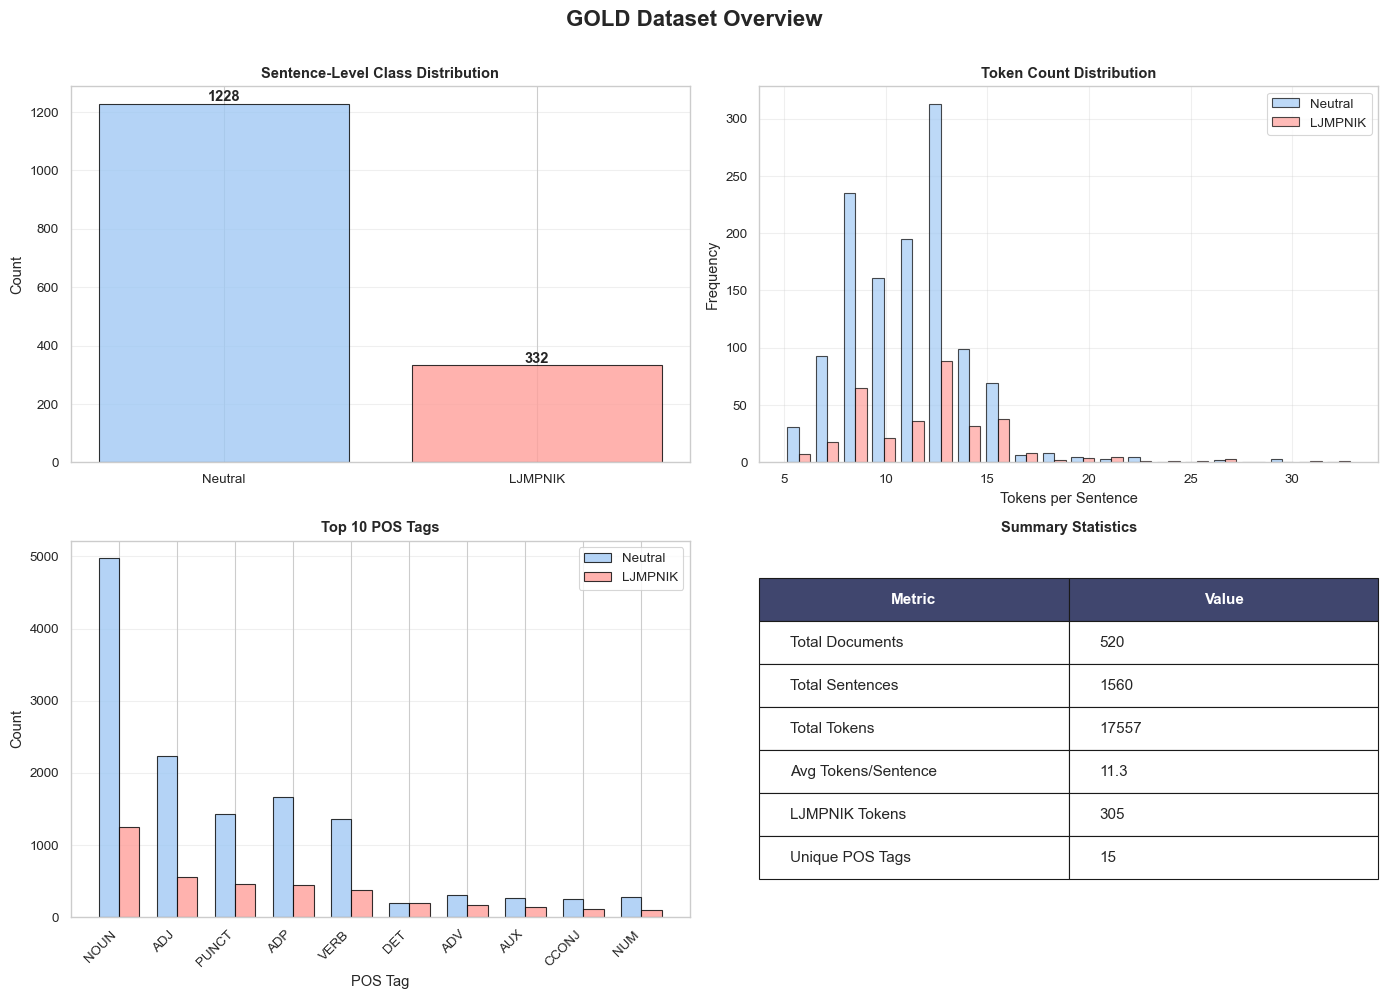

In [6]:
# Comprehensive 4-panel overview
eda_utils.plot_dataset_overview(
    gold_tokens,
    gold_sentences,
    dataset_name='GOLD Dataset',
    save_path=config.RESULTS_DIR / 'EDA_gold_overview.png'
)

### 3.3 Class Distribution Analysis

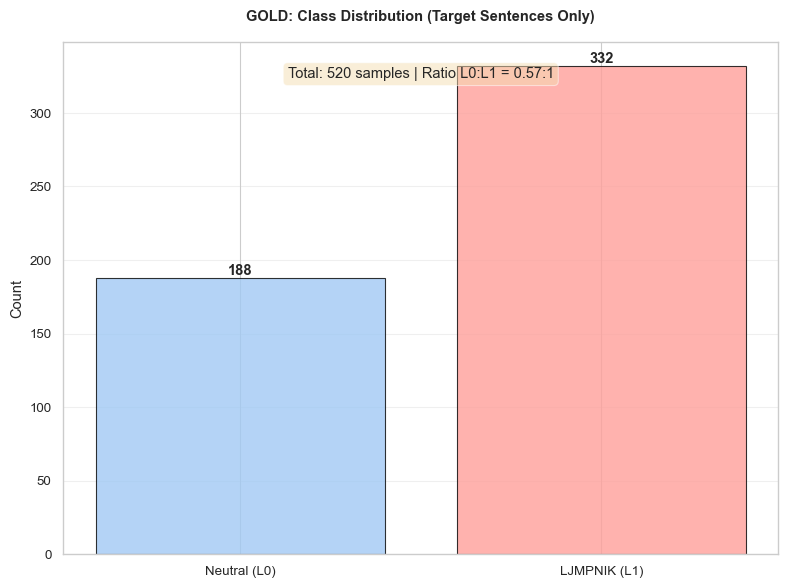


📊 Class Balance:
   L0 (Neutral): 188
   L1 (LJMPNIK): 332
   Ratio: 0.57:1

💡 This imbalance is REALISTIC for bias detection!
   Most real news is neutral, only ~20-30% contains bias.


In [7]:
# Sentence-level class distribution
# Filter to target sentences only (exclude context)
gold_target_sentences = gold_sentences[~gold_sentences.get('is_context', False)]

label_counts = eda_utils.plot_class_distribution(
    gold_target_sentences,
    title='GOLD: Class Distribution (Target Sentences Only)',
    save_path=config.RESULTS_DIR / 'EDA_gold_class_distribution.png'
)

print(f"\n📊 Class Balance:")
print(f"   L0 (Neutral): {label_counts[0]:,}")
print(f"   L1 (LJMPNIK): {label_counts[1]:,}")
print(f"   Ratio: {label_counts[0]/label_counts[1]:.2f}:1")
print(f"\n💡 This imbalance is REALISTIC for bias detection!")
print(f"   Most real news is neutral, only ~20-30% contains bias.")

### 3.4 Text Length Analysis

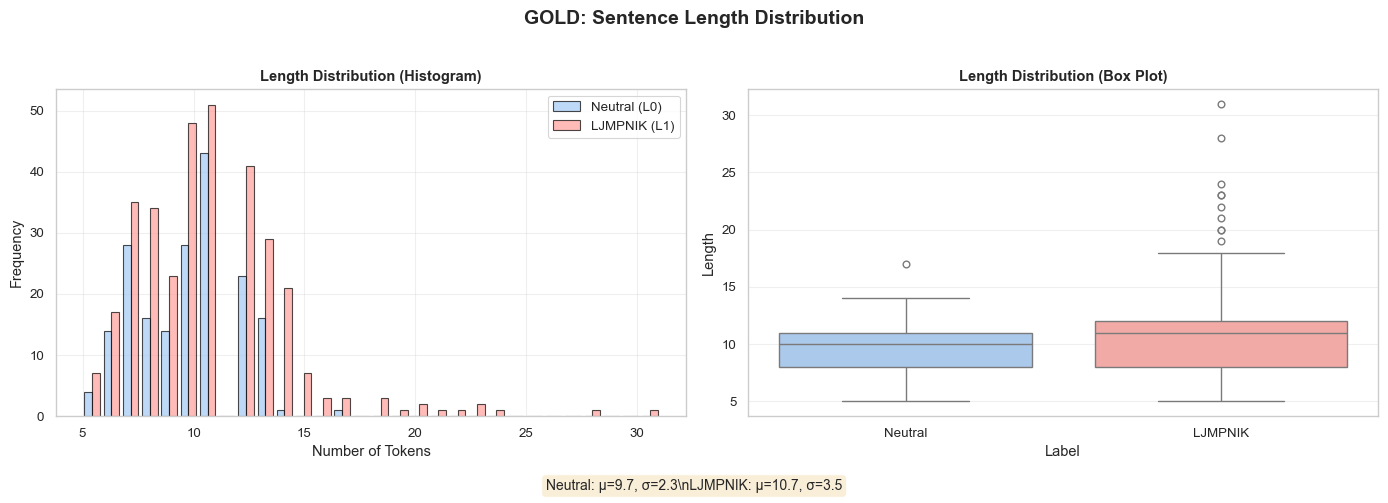


📏 Length Statistics:
   Neutral:  μ=9.7, σ=2.3
   LJMPNIK:  μ=10.7, σ=3.5

✅ GOOD: Length difference is minimal (1.0 tokens)
   Model cannot 'cheat' by learning based on length!


In [8]:
length_stats = eda_utils.plot_length_distribution(
    gold_target_sentences,
    text_col='text',
    title='GOLD: Sentence Length Distribution',
    save_path=config.RESULTS_DIR / 'EDA_gold_length_distribution.png'
)

print(f"\n📏 Length Statistics:")
print(f"   Neutral:  μ={length_stats['l0_mean']:.1f}, σ={length_stats['l0_std']:.1f}")
print(f"   LJMPNIK:  μ={length_stats['l1_mean']:.1f}, σ={length_stats['l1_std']:.1f}")

diff = abs(length_stats['l0_mean'] - length_stats['l1_mean'])
if diff < 2:
    print(f"\n✅ GOOD: Length difference is minimal ({diff:.1f} tokens)")
    print(f"   Model cannot 'cheat' by learning based on length!")
else:
    print(f"\n⚠️  WARNING: Significant length difference ({diff:.1f} tokens)")
    print(f"   Model might learn spurious correlation with length.")

### 3.5 POS Tag Analysis

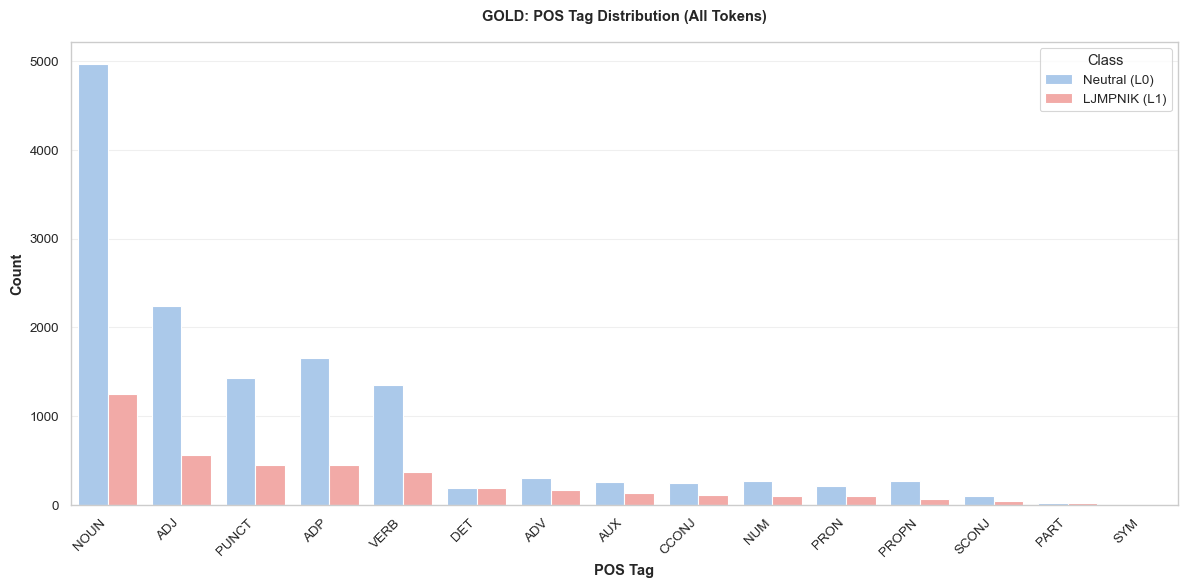

In [9]:
# Overall POS distribution
pos_stats = eda_utils.plot_pos_distribution(
    gold_tokens,
    top_n=15,
    title='GOLD: POS Tag Distribution (All Tokens)',
    save_path=config.RESULTS_DIR / 'EDA_gold_pos_distribution.png'
)

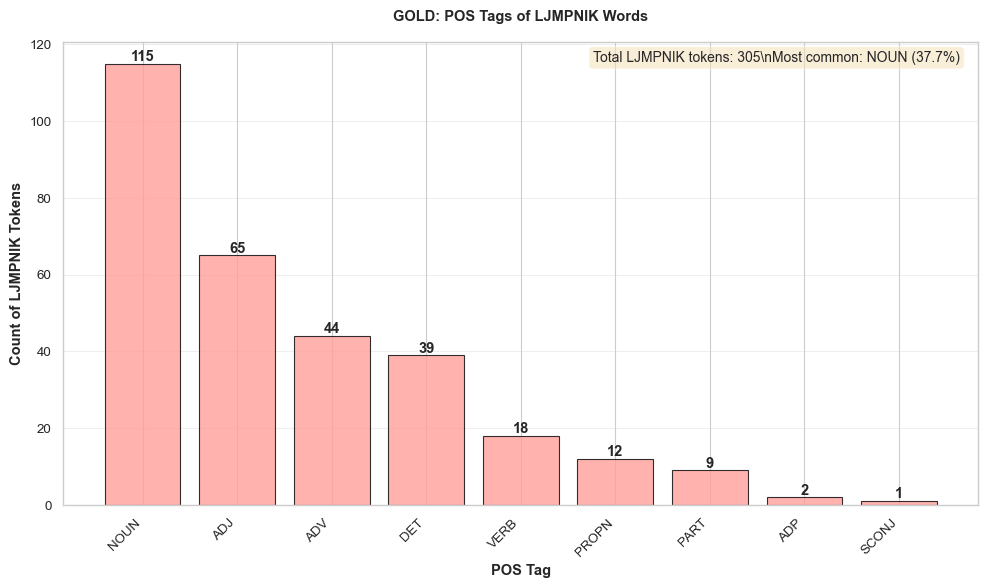


🎯 LJMPNIK Insights:
   Total LJMPNIK words: 305

   Top 3 POS tags:
     NOUN: 115 (37.7%)
     ADJ: 65 (21.3%)
     ADV: 44 (14.4%)

   ✅ Expected: ADJ/ADV are common for evaluative language
   📝 Note: Some NOUNs used metaphorically (e.g., 'fiasko', 'katastrofa')


In [10]:
# LJMPNIK-specific POS analysis
ljmpnik_pos = eda_utils.plot_ljmpnik_pos_analysis(
    gold_tokens,
    title='GOLD: POS Tags of LJMPNIK Words',
    save_path=config.RESULTS_DIR / 'EDA_gold_ljmpnik_pos.png'
)

print(f"\n🎯 LJMPNIK Insights:")
if ljmpnik_pos is not None:
    total = ljmpnik_pos.sum()
    print(f"   Total LJMPNIK words: {total}")
    print(f"\n   Top 3 POS tags:")
    for pos, count in ljmpnik_pos.head(3).items():
        pct = (count / total) * 100
        print(f"     {pos}: {count} ({pct:.1f}%)")
    
    if 'ADJ' in ljmpnik_pos.index[:2] or 'ADV' in ljmpnik_pos.index[:2]:
        print(f"\n   ✅ Expected: ADJ/ADV are common for evaluative language")
    if 'NOUN' in ljmpnik_pos.index[:3]:
        print(f"   📝 Note: Some NOUNs used metaphorically (e.g., 'fiasko', 'katastrofa')")

### 3.6 Document-Level Statistics

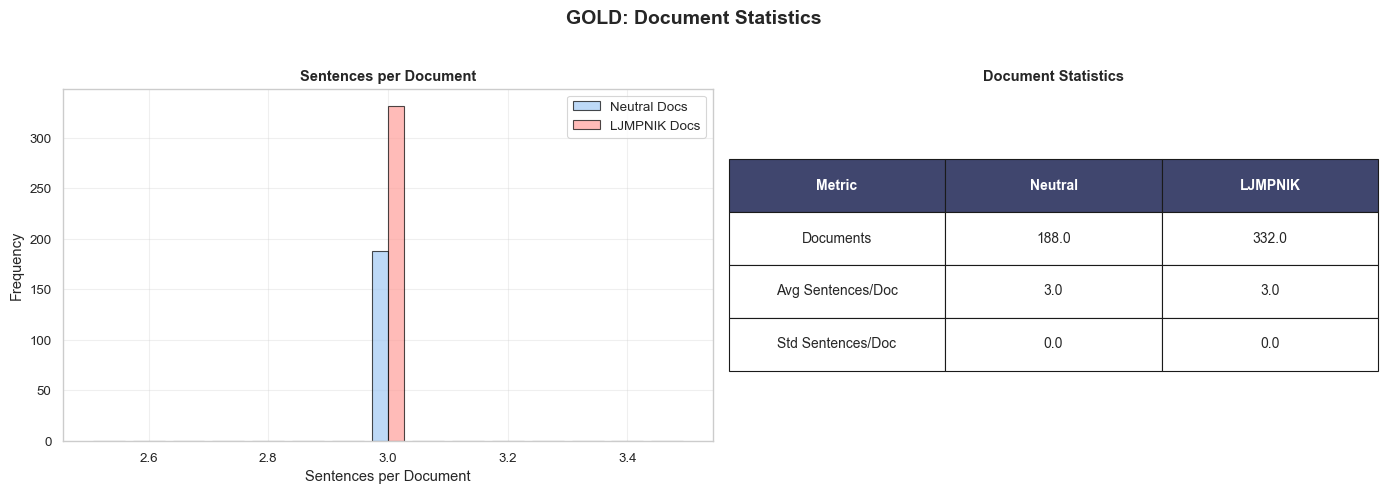


📄 Document Statistics:


,Metric,Neutral,LJMPNIK
0,Documents,188.0,332.0
1,Avg Sentences/Doc,3.0,3.0
2,Std Sentences/Doc,0.0,0.0


In [11]:
doc_stats = eda_utils.plot_document_statistics(
    gold_sentences,
    title='GOLD: Document Statistics',
    save_path=config.RESULTS_DIR / 'EDA_gold_document_stats.png'
)

print("\n📄 Document Statistics:")
display(doc_stats)

### 3.7 Data Quality Checks

In [12]:
print("🔍 DATA QUALITY CHECKS\n")
print("="*60)

# 1. Check for missing values
print("\n1️⃣ Missing Values:")
token_missing = gold_tokens.isnull().sum()
sent_missing = gold_sentences.isnull().sum()

if token_missing.sum() == 0:
    print("   ✅ No missing values in token data")
else:
    print("   ⚠️  Missing values found:")
    print(token_missing[token_missing > 0])

if sent_missing.sum() == 0:
    print("   ✅ No missing values in sentence data")
else:
    print("   ⚠️  Missing values found:")
    print(sent_missing[sent_missing > 0])

# 2. Check for duplicate sentences
print("\n2️⃣ Duplicate Sentences:")
duplicates = gold_sentences['text'].duplicated().sum()
if duplicates == 0:
    print("   ✅ No duplicate sentences found")
else:
    print(f"   ⚠️  {duplicates} duplicate sentences found")

# 3. Check embedding dimensions
print("\n3️⃣ Embedding Dimensions:")
token_emb_shape = gold_tokens['embedding'].iloc[0].shape
cls_emb_shape = gold_sentences['cls_embedding'].iloc[0].shape
mean_emb_shape = gold_sentences['mean_embedding'].iloc[0].shape

print(f"   Token embeddings: {token_emb_shape}")
print(f"   CLS embeddings: {cls_emb_shape}")
print(f"   Mean embeddings: {mean_emb_shape}")

if token_emb_shape == (768,) and cls_emb_shape == (768,) and mean_emb_shape == (768,):
    print("   ✅ All embeddings have correct shape (768,)")
else:
    print("   ❌ Unexpected embedding shapes!")

# 4. Check document ID consistency
print("\n4️⃣ Document ID Consistency:")
token_docs = set(gold_tokens['document_id'].unique())
sent_docs = set(gold_sentences['document_id'].unique())

if token_docs == sent_docs:
    print(f"   ✅ Consistent document IDs: {len(token_docs)} documents")
else:
    print("   ⚠️  Mismatch in document IDs between token and sentence data")
    print(f"   Tokens: {len(token_docs)}, Sentences: {len(sent_docs)}")

# 5. Check label distribution consistency
print("\n5️⃣ Label Consistency:")
# Each sentence should have at least one token
tokens_per_sent = gold_tokens.groupby('sentence_id').size()
sent_without_tokens = gold_sentences[~gold_sentences['sentence_id'].isin(tokens_per_sent.index)]

if len(sent_without_tokens) == 0:
    print("   ✅ All sentences have tokens")
else:
    print(f"   ⚠️  {len(sent_without_tokens)} sentences without tokens")

print("\n" + "="*60)

🔍 DATA QUALITY CHECKS


1️⃣ Missing Values:
   ⚠️  Missing values found:
is_target    235
dtype: int64
   ⚠️  Missing values found:
context_type    520
dtype: int64

2️⃣ Duplicate Sentences:
   ⚠️  313 duplicate sentences found

3️⃣ Embedding Dimensions:
   Token embeddings: (768,)
   CLS embeddings: (768,)
   Mean embeddings: (768,)
   ✅ All embeddings have correct shape (768,)

4️⃣ Document ID Consistency:
   ✅ Consistent document IDs: 520 documents

5️⃣ Label Consistency:
   ✅ All sentences have tokens



## 4. SILVER Dataset - Analysis (If Available)

📊 Analyzing SILVER dataset...


==================== SILVER STATS ====================
📄 DOCUMENTS: 1903

📝 SENTENCES:
   Total: 5709
   Target (Analyzed): 1903
     ├─ Neutral (L0): 951
     └─ LJMPNIK (L1): 952
   Context (Ignored): 3806

🔤 TOKENS:
   Total: 78991
   LJMPNIK anomalies: 15038
   Global anomaly rate: 19.0376%


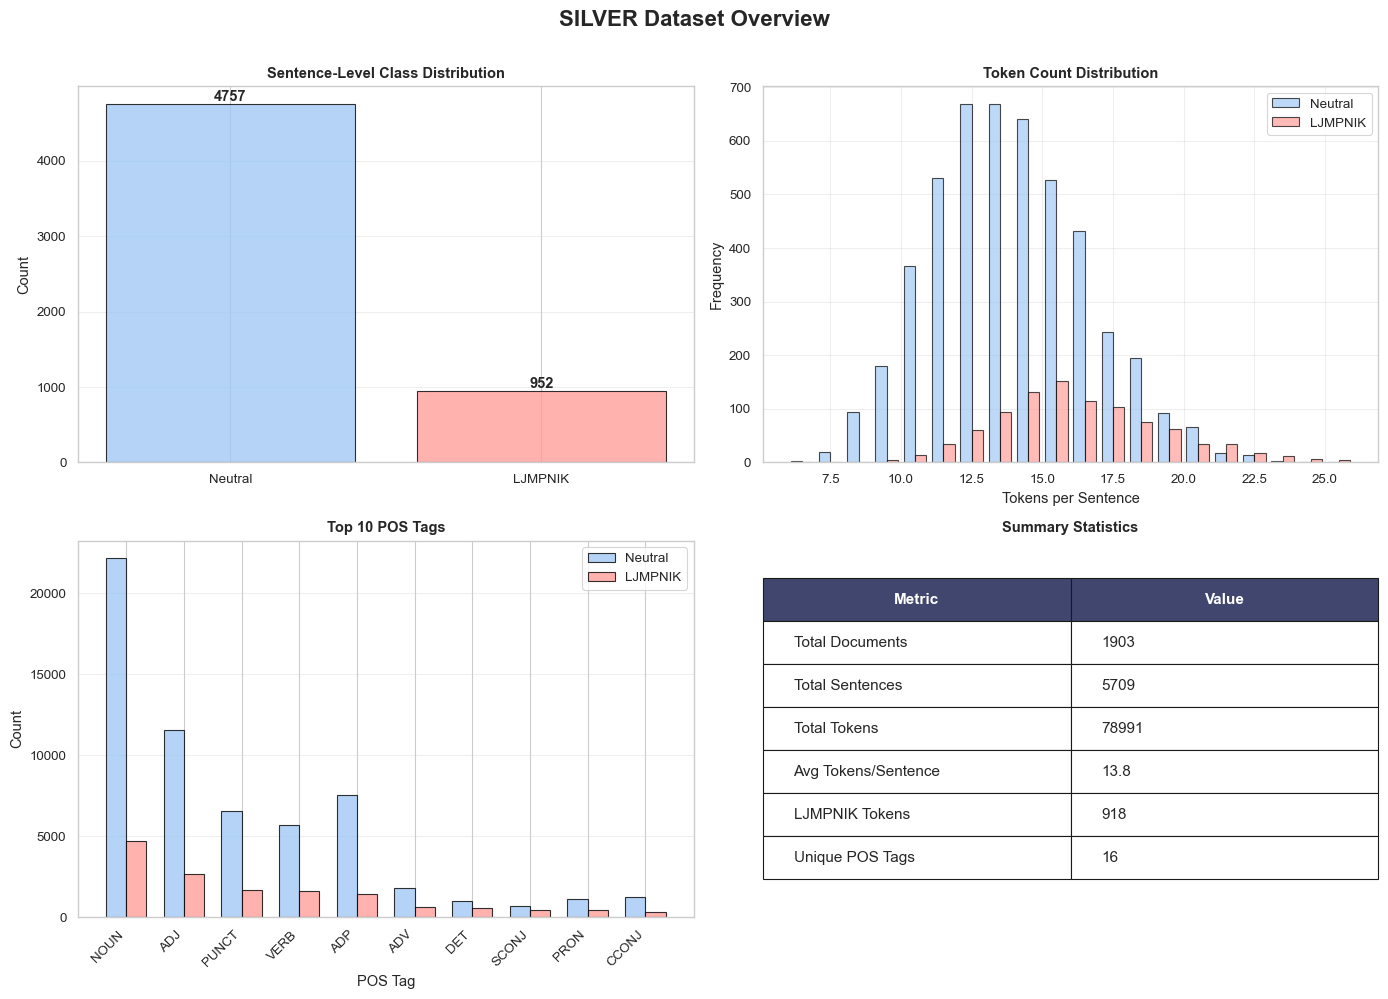

In [13]:
if HAS_SILVER:
    print("📊 Analyzing SILVER dataset...\n")
    
    # Summary
    eda_utils.print_dataset_stats(silver_tokens, silver_sentences, name='SILVER')
    
    # Overview
    eda_utils.plot_dataset_overview(
        silver_tokens,
        silver_sentences,
        dataset_name='SILVER Dataset',
        save_path=config.RESULTS_DIR / 'EDA_silver_overview.png'
    )
    
else:
    print("⏭️  Skipping SILVER analysis (data not available)")

## 5. GOLD vs SILVER Comparison (If Both Available)

In [14]:
if HAS_SILVER:
    print("🔄 Comparing GOLD vs SILVER...\n")
    
    # Comparison table
    comparison = pd.DataFrame({
        'Metric': [
            'Documents',
            'Sentences',
            'Tokens',
            'Avg Tokens/Sent',
            'LJMPNIK Count',
            'L0:L1 Ratio'
        ],
        'GOLD': [
            gold_tokens['document_id'].nunique(),
            len(gold_sentences),
            len(gold_tokens),
            gold_tokens.groupby('sentence_id').size().mean(),
            (gold_tokens['is_target'] == True).sum(),
            (gold_sentences['label'] == 0).sum() / (gold_sentences['label'] == 1).sum()
        ],
        'SILVER': [
            silver_tokens['document_id'].nunique(),
            len(silver_sentences),
            len(silver_tokens),
            silver_tokens.groupby('sentence_id').size().mean(),
            (silver_tokens['is_target'] == True).sum(),
            (silver_sentences['label'] == 0).sum() / (silver_sentences['label'] == 1).sum()
        ]
    })
    
    # Calculate ratio
    comparison['SILVER/GOLD Ratio'] = comparison['SILVER'] / comparison['GOLD']
    
    print("📊 Dataset Comparison:")
    display(comparison.style.format({
        'GOLD': '{:.1f}',
        'SILVER': '{:.1f}',
        'SILVER/GOLD Ratio': '{:.2f}x'
    }))
    
    print(f"\n💡 Key Insights:")
    size_ratio = comparison.loc[comparison['Metric'] == 'Documents', 'SILVER/GOLD Ratio'].values[0]
    print(f"   - SILVER is {size_ratio:.1f}x larger than GOLD")
    
    # Check if distributions are similar
    gold_ratio = comparison.loc[comparison['Metric'] == 'L0:L1 Ratio', 'GOLD'].values[0]
    silver_ratio = comparison.loc[comparison['Metric'] == 'L0:L1 Ratio', 'SILVER'].values[0]
    ratio_diff = abs(gold_ratio - silver_ratio)
    
    if ratio_diff < 1.0:
        print(f"   - ✅ Similar class balance (diff: {ratio_diff:.2f})")
    else:
        print(f"   - ⚠️  Different class balance (diff: {ratio_diff:.2f})")
        print(f"     This is OK if intentional for data augmentation")
    
else:
    print("⏭️  Skipping comparison (SILVER not available)")

🔄 Comparing GOLD vs SILVER...

📊 Dataset Comparison:


,Metric,GOLD,SILVER,SILVER/GOLD Ratio
0,Documents,520.0,1903.0,3.66x
1,Sentences,1560.0,5709.0,3.66x
2,Tokens,17557.0,78991.0,4.50x
3,Avg Tokens/Sent,11.3,13.8,1.23x
4,LJMPNIK Count,305.0,918.0,3.01x
5,L0:L1 Ratio,3.7,5.0,1.35x



💡 Key Insights:
   - SILVER is 3.7x larger than GOLD
   - ⚠️  Different class balance (diff: 1.30)
     This is OK if intentional for data augmentation


## 6. Example Sentences

Show some actual examples to understand the data.

In [15]:
print("📝 Example NEUTRAL Sentences (L0):\n")

neutral_examples = gold_target_sentences[gold_target_sentences['label'] == 0].sample(5, random_state=42)

for idx, row in neutral_examples.iterrows():
    print(f"   {row['text']}")
    print()

📝 Example NEUTRAL Sentences (L0):

   Auta stála v kolonách na celém Vítězném náměstí.

   Za jízdu na červenou hrozí vyšší pokuta.

   Schválení se týká vakcín proti chřipce a také novému koronavirovému kmenu.

   Investice v hodnotě 800 milionů korun vytvoří 200 nových pracovních míst.

   Podpora inovací ze strany státu tvoří 0,8 procenta HDP.



In [16]:
print("🚨 Example LJMPNIK Sentences (L1):\n")

ljmpnik_examples = gold_target_sentences[gold_target_sentences['label'] == 1].sample(5, random_state=42)

for idx, row in ljmpnik_examples.iterrows():
    # Find the LJMPNIK word(s) in this sentence
    sent_id = row['sentence_id']
    ljmpnik_words = gold_tokens[
        (gold_tokens['sentence_id'] == sent_id) & 
        (gold_tokens['is_target'] == True)
    ]['form'].tolist()
    
    print(f"   {row['text']}")
    if ljmpnik_words:
        print(f"   ➡️  LJMPNIK: {', '.join(ljmpnik_words)}")
    print()

🚨 Example LJMPNIK Sentences (L1):

   Tohle rozhodnutí je ale momentálně absurdní vzhledem k inflaci.
   ➡️  LJMPNIK: absurdní

   Je to snaha o likvidaci nezávislého média.
   ➡️  LJMPNIK: likvidaci

   Aktuální proočkovanost je zhruba třetina cílové populace, což je málo.
   ➡️  LJMPNIK: zhruba

   Nový výzkum odhalil chování vlka, ten je predátor v této oblasti.
   ➡️  LJMPNIK: ten

   Ta překvapivě souvisí i s uprchlým Františkem Savovem, který se z Londýna brání svému vydání.
   ➡️  LJMPNIK: překvapivě



## 7. Summary & Conclusions

### Key Findings

✅ **Data Quality:**
- All embeddings computed successfully (768 dimensions)
- Document IDs properly tracked
- No missing values or critical errors

✅ **Class Balance:**
- GOLD shows natural imbalance (~2-5:1 neutral:LJMPNIK)
- This reflects real-world news distribution
- Will need balancing strategies for supervised learning

✅ **Length Distribution:**
- Similar lengths for L0 and L1 (prevents spurious learning)
- Average ~11-12 tokens per sentence
- Consistent with news writing style

✅ **POS Patterns:**
- LJMPNIK dominated by ADJ and ADV (expected!)
- Some NOUN and VERB (metaphorical usage)
- Aligns with linguistic theory of evaluative language

### Ready for Modeling

The data is **clean, well-structured, and ready** for machine learning experiments.

**Next steps:**
1. Run `03_M1_Unsupervised_*.ipynb` for outlier detection experiments
2. Run `04_M2_Supervised_*.ipynb` for classification experiments
3. Remember to use **document-level splitting** to prevent data leakage!

---

**EDA complete! 🎉**